In [ ]:
%pip install  --upgrade \
  datasets \
  transformers==4.37.2 \
  accelerate==0.26.1 \
  evaluate==0.4.1 \
  bitsandbytes==0.42.0 \
  trl==0.7.11 \
  peft==0.8.2

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import ast
import warnings
import torch
from tqdm.notebook import tqdm

# torch.backends.cuda.enable_mem_efficient_sdp(False)
# torch.backends.cuda.enable_flash_sdp(True)

warnings.filterwarnings('ignore')

In [4]:
ds = load_dataset("OpenAssistant/oasst1")

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
        num_rows: 84437
    })
    validation: Dataset({
        features: ['message_id', 'parent_id', 'user_id', 'created_date', 'text', 'role', 'lang', 'review_count', 'review_result', 'deleted', 'rank', 'synthetic', 'model_name', 'detoxify', 'message_tree_id', 'tree_state', 'emojis', 'labels'],
        num_rows: 4401
    })
})

In [6]:
df = ds['train'].to_pandas()
df.head()

,message_id,parent_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,rank,synthetic,model_name,detoxify,message_tree_id,tree_state,emojis,labels
0,6ab24d72-0181-4594-a9cd-deaf170242fb,None,c3fe8c76-fc30-4fa7-b7f8-c492f5967d18,2023-02-05T14:23:50.983374+00:00,Can you write a short introduction about the r...,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.00044308538781479, 'severe_toxi...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
1,c8e83833-ecbc-44fe-b6db-735228c25a1c,6ab24d72-0181-4594-a9cd-deaf170242fb,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T13:50:44.657083+00:00,"""Monopsony"" refers to a market structure where...",assistant,en,3,True,False,0.0,False,None,"{'toxicity': 0.00026396565954200923, 'severe_t...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_labeling'], 'count': [3...","{'name': ['spam', 'fails_task', 'lang_mismatch..."
2,6708c47f-05c9-4346-b3d2-40b2bd24fde4,c8e83833-ecbc-44fe-b6db-735228c25a1c,2c96e467-66f0-4be7-9693-bda51356a424,2023-02-06T18:48:49.391686+00:00,Now explain it to a dog,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.03648477792739868, 'severe_toxi...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,None,"{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
3,343ee2d4-87ae-41fd-a768-bdd65959dc4a,6ab24d72-0181-4594-a9cd-deaf170242fb,49ddcb0d-6588-43bd-858d-19c577f12e7b,2023-02-06T13:37:56.044680+00:00,Monopsony is a market structure in which there...,assistant,en,3,True,False,1.0,False,None,"{'toxicity': 0.0008866374846547842, 'severe_to...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_labeling...","{'name': ['spam', 'fails_task', 'lang_mismatch..."
4,18145bf4-37fd-4ac0-80f5-6108b5f2b365,343ee2d4-87ae-41fd-a768-bdd65959dc4a,e10e99a0-38ac-4b07-bf5d-4427696e4e0d,2023-02-06T18:52:51.428543+00:00,How can one fight back when a monospony had be...,prompter,en,3,True,False,NaN,False,None,"{'toxicity': 0.0009362137061543763, 'severe_to...",6ab24d72-0181-4594-a9cd-deaf170242fb,ready_for_export,"{'name': ['+1'], 'count': [1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


In [7]:
df['lang'].unique()

array(['en', 'es', 'de', 'ru', 'ja', 'pt-BR', 'ca', 'fr', 'pl', 'vi',
       'zh', 'hu', 'ko', 'eu', 'it', 'uk-UA', 'id', 'ar', 'fi', 'tr',
       'da', 'th', 'sv', 'cs'], dtype=object)

In [8]:
df['role'].unique()

array(['prompter', 'assistant'], dtype=object)

In [9]:
top_lvl_ru_instruct = df[(df['lang'] == 'ru') &\
                         (df['role'] == 'prompter') &\
                         (df['parent_id'].isna())]

In [10]:
top_lvl_ru_instruct.head()

,message_id,parent_id,user_id,created_date,text,role,lang,review_count,review_result,deleted,rank,synthetic,model_name,detoxify,message_tree_id,tree_state,emojis,labels
82,e480f611-0d31-433a-93d2-0e2bc675aa30,None,05a999f8-8219-4584-a3f2-d4b4aec30027,2023-02-06T23:09:05.356836+00:00,Напиши информацию о игре Hytale,prompter,ru,3,True,False,NaN,False,None,"{'toxicity': 0.0008757906034588814, 'severe_to...",e480f611-0d31-433a-93d2-0e2bc675aa30,ready_for_export,"{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
185,fa8c92d6-6daa-42a3-a2f5-e2e0eb610c41,None,19241e3c-8272-4c3f-afe8-527c005d042c,2023-02-07T14:36:48.863674+00:00,"Докончи поговорку, без труда не выловишь и",prompter,ru,3,True,False,NaN,False,None,"{'toxicity': 0.0432540699839592, 'severe_toxic...",fa8c92d6-6daa-42a3-a2f5-e2e0eb610c41,ready_for_export,"{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
315,ef69d986-aa2d-4c3e-a122-1910d9625c79,None,6b1efbfa-7c16-47bf-b90c-340ab2b1b7eb,2023-02-08T14:59:45.846381+00:00,"У меня угнали машину, что мне делать?",prompter,ru,3,True,False,NaN,False,None,"{'toxicity': 0.004925671499222517, 'severe_tox...",ef69d986-aa2d-4c3e-a122-1910d9625c79,ready_for_export,"{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
327,e321f8f6-01f8-4975-afe6-73db989f538e,None,3c8cde8c-9466-494f-9c36-cbf3c3ac7ecd,2023-02-08T14:19:18.286994+00:00,Какие произведения Булгакова связаны с Иерусал...,prompter,ru,3,True,False,NaN,False,None,"{'toxicity': 0.0015869040507823229, 'severe_to...",e321f8f6-01f8-4975-afe6-73db989f538e,ready_for_export,"{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
427,5083658c-e251-4259-b180-77afaf907d66,None,05a999f8-8219-4584-a3f2-d4b4aec30027,2023-02-07T15:32:50.130297+00:00,Плюсы и минусы языков программирования C++ и R...,prompter,ru,3,True,False,NaN,False,None,"{'toxicity': 0.0003262242244090885, 'severe_to...",5083658c-e251-4259-b180-77afaf907d66,ready_for_export,"{'name': ['+1', '_skip_reply'], 'count': [6, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


In [11]:
cols_to_drop = ['message_id', 'parent_id', 'user_id', 'created_date', 'role',
                'lang', 'model_name', 'message_tree_id', 'tree_state']
top_lvl_ru_instruct = top_lvl_ru_instruct.drop(cols_to_drop, axis=1)

In [12]:
top_lvl_ru_instruct.head()

,text,review_count,review_result,deleted,rank,synthetic,detoxify,emojis,labels
82,Напиши информацию о игре Hytale,3,True,False,NaN,False,"{'toxicity': 0.0008757906034588814, 'severe_to...","{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
185,"Докончи поговорку, без труда не выловишь и",3,True,False,NaN,False,"{'toxicity': 0.0432540699839592, 'severe_toxic...","{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
315,"У меня угнали машину, что мне делать?",3,True,False,NaN,False,"{'toxicity': 0.004925671499222517, 'severe_tox...","{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
327,Какие произведения Булгакова связаны с Иерусал...,3,True,False,NaN,False,"{'toxicity': 0.0015869040507823229, 'severe_to...","{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
427,Плюсы и минусы языков программирования C++ и R...,3,True,False,NaN,False,"{'toxicity': 0.0003262242244090885, 'severe_to...","{'name': ['+1', '_skip_reply'], 'count': [6, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


In [13]:
top_lvl_ru_instruct.shape

(721, 9)

In [14]:
top_lvl_ru_instruct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 721 entries, 82 to 83866
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text           721 non-null    object 
 1   review_count   721 non-null    int32  
 2   review_result  721 non-null    object 
 3   deleted        721 non-null    bool   
 4   rank           0 non-null      float64
 5   synthetic      721 non-null    bool   
 6   detoxify       721 non-null    object 
 7   emojis         721 non-null    object 
 8   labels         721 non-null    object 
dtypes: bool(2), float64(1), int32(1), object(5)
memory usage: 43.7+ KB


In [15]:
print(top_lvl_ru_instruct['review_result'].unique())
print(top_lvl_ru_instruct['deleted'].unique())
print(top_lvl_ru_instruct['synthetic'].unique())

[True]
[False]
[False]


In [16]:
top_lvl_ru_instruct = top_lvl_ru_instruct.drop(['rank', 'review_result', 'deleted', 'synthetic'], axis=1)

In [17]:
top_lvl_ru_instruct.head()

,text,review_count,detoxify,emojis,labels
82,Напиши информацию о игре Hytale,3,"{'toxicity': 0.0008757906034588814, 'severe_to...","{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
185,"Докончи поговорку, без труда не выловишь и",3,"{'toxicity': 0.0432540699839592, 'severe_toxic...","{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
315,"У меня угнали машину, что мне делать?",3,"{'toxicity': 0.004925671499222517, 'severe_tox...","{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
327,Какие произведения Булгакова связаны с Иерусал...,3,"{'toxicity': 0.0015869040507823229, 'severe_to...","{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."
427,Плюсы и минусы языков программирования C++ и R...,3,"{'toxicity': 0.0003262242244090885, 'severe_to...","{'name': ['+1', '_skip_reply'], 'count': [6, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not..."


In [18]:
top_lvl_ru_instruct['text_len'] = top_lvl_ru_instruct['text'].apply(len)

<Axes: xlabel='text_len', ylabel='Count'>

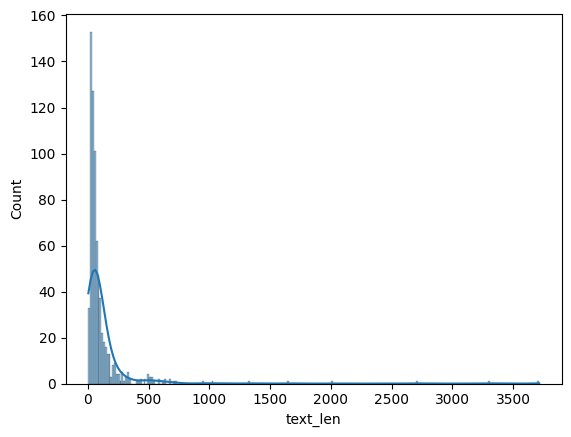

In [19]:
sns.histplot(data=top_lvl_ru_instruct, x="text_len", kde=True)

In [20]:
top_lvl_ru_instruct['text_len'].describe()

count     721.000000
mean      112.907074
std       257.021267
min         3.000000
25%        33.000000
50%        55.000000
75%       101.000000
max      3714.000000
Name: text_len, dtype: float64

In [21]:
min_text_len = top_lvl_ru_instruct['text_len'].min()
max_text_len = top_lvl_ru_instruct['text_len'].max()

In [22]:
top_lvl_ru_instruct.query(f"text_len == {min_text_len}")['text'].values

array(['2+2'], dtype=object)

In [23]:
top_lvl_ru_instruct.query(f"text_len == {max_text_len}")['text'].values

array(['Я хочу, чтобы ты вёл себя как рассказчик анекдотов и отвечал мне нуждиками или в стиле нуждиков. Сейчас объясню, что это такое. Нуждики - это упоротые, постироничные и ржачные анекдоты, которые читал Александр Нуждин в своей передаче "Нуждики". Нуждики отличаются саркастичностью и своей острой ироничностью, перешанной с наркоманскими темами и, на первый взгляд, бессвязной, но очень смешной игрой слова. После каждого анекдота издаётся громкий "Фить Ха!"\nНапример: \nДесерт 15, бутылка вина 25 всего 65, а у вас - 110! Это как же так получилось? Официант с досадой: А приятно. Фить ха! \n\nЕсли дверь в туалете закрывается со звуком "фить", это значит в туалете нет чувства юмора.\n\nГлухой пациент принимается у терапевта. Терапевт ему такой:\n-да у вас, голубчик, гепатит.\n-А?\n-Б!\nФить ха!\n\nХорошо смеётся тот, у кого бабушка шире. Фить ха!\n\nВыходят мужики из лесу, видят - дед на бутылке сидит, они ему - дедушка, подвинься пожалуйста. Фить ха!\n\nКогда бандиты начинают выламыва

In [24]:
top_lvl_ru_instruct['review_count'].unique()

array([3, 4, 5], dtype=int32)

<Axes: xlabel='review_count', ylabel='Count'>

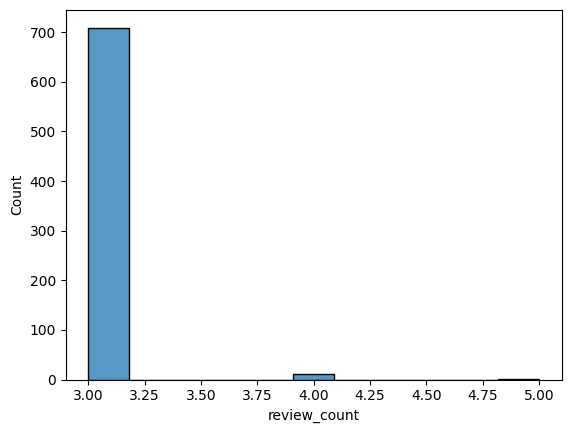

In [25]:
sns.histplot(data=top_lvl_ru_instruct, x="review_count")

In [26]:
top_lvl_ru_instruct.query(f"review_count == 5")

,text,review_count,detoxify,emojis,labels,text_len
23970,Почему нейронная сеть beta.character.ai не мож...,5,"{'toxicity': 0.0008789007551968098, 'severe_to...","{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",135


In [27]:
top_lvl_ru_instruct

,text,review_count,detoxify,emojis,labels,text_len
82,Напиши информацию о игре Hytale,3,"{'toxicity': 0.0008757906034588814, 'severe_to...","{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",31
185,"Докончи поговорку, без труда не выловишь и",3,"{'toxicity': 0.0432540699839592, 'severe_toxic...","{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",42
315,"У меня угнали машину, что мне делать?",3,"{'toxicity': 0.004925671499222517, 'severe_tox...","{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",37
327,Какие произведения Булгакова связаны с Иерусал...,3,"{'toxicity': 0.0015869040507823229, 'severe_to...","{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",51
427,Плюсы и минусы языков программирования C++ и R...,3,"{'toxicity': 0.0003262242244090885, 'severe_to...","{'name': ['+1', '_skip_reply'], 'count': [6, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",61
...,...,...,...,...,...,...
83508,Что такое любовь?,3,"{'toxicity': 0.0009237665799446404, 'severe_to...","{'name': ['+1', '_skip_reply'], 'count': [3, 4]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",17
83534,Сколько времени нужно чтобы обучить нейронную ...,3,"{'toxicity': 0.001400097506120801, 'severe_tox...","{'name': ['+1', '_skip_reply'], 'count': [4, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",51
83546,Напиши список лучших программ для фотограмметр...,3,"{'toxicity': 0.0006068239454180002, 'severe_to...","{'name': ['+1', '_skip_reply'], 'count': [4, 10]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",86
83703,Каковы преимущества занятий йогой и медитацией?,3,"{'toxicity': 0.00043142051436007023, 'severe_t...","{'name': ['+1', '_skip_reply'], 'count': [1, 5]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",47


In [28]:
top_lvl_ru_instruct.iloc[0, 1]

3

In [29]:
top_lvl_ru_instruct['detoxify'] = top_lvl_ru_instruct.apply(lambda row: {**row['detoxify'], 'index': row.name}, axis=1)
detoxify = pd.json_normalize(top_lvl_ru_instruct['detoxify'])

In [30]:
detoxify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   toxicity         721 non-null    float64
 1   severe_toxicity  721 non-null    float64
 2   obscene          721 non-null    float64
 3   identity_attack  721 non-null    float64
 4   insult           721 non-null    float64
 5   threat           721 non-null    float64
 6   sexual_explicit  721 non-null    float64
 7   index            721 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 45.2 KB


In [31]:
top_lvl_ru_instruct = top_lvl_ru_instruct.merge(detoxify, 'left', left_index=True, right_on='index')
top_lvl_ru_instruct = top_lvl_ru_instruct.drop('detoxify', axis=1)

In [32]:
top_lvl_ru_instruct.head()

,text,review_count,emojis,labels,text_len,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,index
0,Напиши информацию о игре Hytale,3,"{'name': ['+1', '_skip_ranking', '_skip_labeli...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",31,0.000876,0.006206,0.039024,0.007062,0.031851,0.002483,0.001191,82
1,"Докончи поговорку, без труда не выловишь и",3,"{'name': ['+1', '-1'], 'count': [3, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",42,0.043254,0.000322,0.003794,0.000290,0.009484,0.017009,0.001749,185
2,"У меня угнали машину, что мне делать?",3,"{'name': ['+1', '_skip_reply'], 'count': [4, 1]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",37,0.004926,0.000403,0.003004,0.000552,0.001443,0.002428,0.000256,315
3,Какие произведения Булгакова связаны с Иерусал...,3,"{'name': ['+1', '_skip_reply', '_skip_ranking'...","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",51,0.001587,0.000459,0.003759,0.002968,0.003093,0.000296,0.000162,327
4,Плюсы и минусы языков программирования C++ и R...,3,"{'name': ['+1', '_skip_reply'], 'count': [6, 3]}","{'name': ['spam', 'lang_mismatch', 'pii', 'not...",61,0.000326,0.001647,0.014770,0.002219,0.012556,0.000652,0.000408,427


В статье про датасет говорится что сообщения которые успешно прошли модерацию имееют низкие значения по всех критериям токсичности

In [33]:
top_lvl_ru_instruct.describe()

,review_count,text_len,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,index
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000
mean,3.018031,112.907074,0.022952,0.000860,0.008728,0.002345,0.012910,0.003522,0.002017,42667.958391
std,0.143205,257.021267,0.090571,0.001463,0.021664,0.026059,0.043629,0.035053,0.025751,24164.864665
min,3.000000,3.000000,0.000226,0.000017,0.000157,0.000064,0.000189,0.000022,0.000023,82.000000
25%,3.000000,33.000000,0.000638,0.000068,0.000718,0.000178,0.000776,0.000103,0.000073,21773.000000
50%,3.000000,55.000000,0.001204,0.000176,0.002313,0.000387,0.002443,0.000279,0.000205,40402.000000
75%,3.000000,101.000000,0.004329,0.000832,0.010354,0.001480,0.011663,0.001065,0.000552,63930.000000
max,5.000000,3714.000000,0.840749,0.008296,0.490172,0.698293,0.693210,0.766309,0.614887,83866.000000


In [34]:
detoxify_cols = ['toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

for col in detoxify_cols:
    max_val = top_lvl_ru_instruct[col].max()
    print(col)
    print(top_lvl_ru_instruct.query(f"{col} == {max_val}")['text'].values)

toxicity
['Можно ли убить во благо?']
severe_toxicity
['Привет, можешь ли ты написать игру на C++ и OpenGL? Предоставь мне инструкцию как скомпилировать это спомощью G++ и напиши мне Makefile для этого']
obscene
['Ох, блин, я задумался и забыл сменить раскладку клавиатуры, когда писал. Можешь её поправить, как это делает гугл? Вот предложение:\n"nj ;t njn cfvsq jgty fccbcnfyn? rjnjhsv vj;yj gjkmpjdfnmcz ,tcgkfnyj b yt ,jzcm? xnj rnj-nj pf,th§n ndjb lfyyst']
identity_attack
['Плохо ли быть геем?']
insult
['Милая Ася, скажи, зачем я в пятом часу ночи задаю тебе дурацкие вопросы вместо того, чтобы смотреть десятый сон? Что со мной не так? Спать ведь надо ночью, а не отправлять свои нелепые вопросы в пустоту Вселенной…']
threat
['Можно ли убить во благо?']


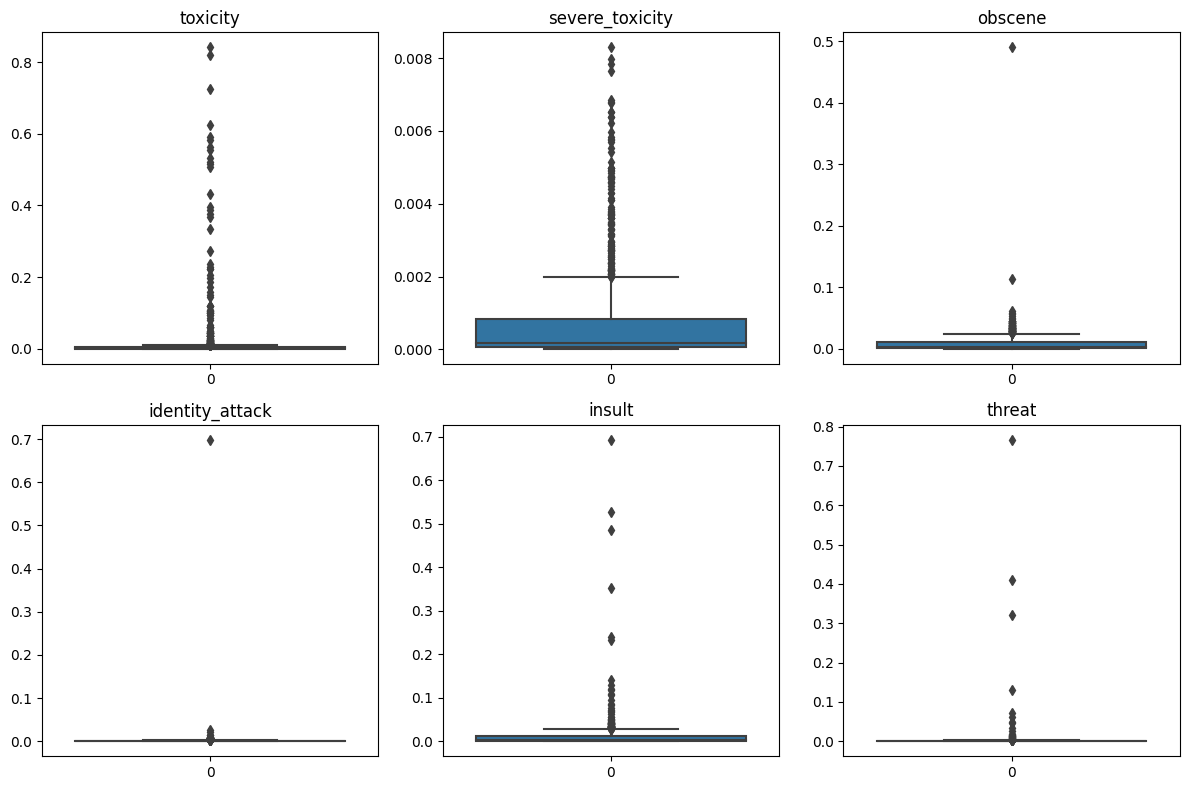

In [35]:


# Устанавливаем размер графиков
plt.figure(figsize=(12, 8))

# Цикл по колонкам и построение гистограмм
for i, column in enumerate(detoxify_cols, 1):
    plt.subplot(2, 3, i)  # Подсетка 2 строки, 3 колонки
    sns.boxplot(top_lvl_ru_instruct[column])  # Строим гистограмму с KDE
    plt.title(column)  # Название каждого графика

# Отображаем графики
plt.tight_layout()  # Оптимизируем размещение
plt.show()

In [36]:
for col in detoxify_cols:
    top_lvl_ru_instruct = top_lvl_ru_instruct[top_lvl_ru_instruct[col] <= 0.7]

In [37]:
top_lvl_ru_instruct.shape

(718, 13)

In [38]:
top_lvl_ru_instruct = top_lvl_ru_instruct.rename(columns={'toxicity': 'toxicity_detoxify'})

In [39]:
top_lvl_ru_instruct = top_lvl_ru_instruct.drop('emojis', axis=1)

In [40]:
top_lvl_ru_instruct['labels']

0      {'name': ['spam', 'lang_mismatch', 'pii', 'not...
1      {'name': ['spam', 'lang_mismatch', 'pii', 'not...
2      {'name': ['spam', 'lang_mismatch', 'pii', 'not...
3      {'name': ['spam', 'lang_mismatch', 'pii', 'not...
4      {'name': ['spam', 'lang_mismatch', 'pii', 'not...
                             ...                        
716    {'name': ['spam', 'lang_mismatch', 'pii', 'not...
717    {'name': ['spam', 'lang_mismatch', 'pii', 'not...
718    {'name': ['spam', 'lang_mismatch', 'pii', 'not...
719    {'name': ['spam', 'lang_mismatch', 'pii', 'not...
720    {'name': ['spam', 'lang_mismatch', 'pii', 'not...
Name: labels, Length: 718, dtype: object

In [41]:
labels_names = []
for i in range(len(top_lvl_ru_instruct)):
    labels = top_lvl_ru_instruct.iloc[i, 2]['name']
    for lbl in labels:
        if lbl not in labels_names:
            labels_names.append(lbl)
print(labels_names)

['spam', 'lang_mismatch', 'pii', 'not_appropriate', 'hate_speech', 'sexual_content', 'quality', 'toxicity', 'humor', 'creativity', 'violence', 'helpfulness']


In [42]:
names_df = []

for i in range(len(top_lvl_ru_instruct)):
    names = top_lvl_ru_instruct.iloc[i, 2]['name']
    values = top_lvl_ru_instruct.iloc[i, 2]['value']
    new_labels = {x: None for x in labels_names}
    for n, v in zip(names, values):
        new_labels[n] = v
    names_df.append(new_labels)

names_df = pd.DataFrame(names_df)

In [43]:
top_lvl_ru_instruct = top_lvl_ru_instruct.reset_index(drop=True)
top_lvl_ru_instruct = top_lvl_ru_instruct.merge(names_df, 'left', left_index=True, right_index=True)

In [44]:
top_lvl_ru_instruct[labels_names].isna().sum()

spam                 0
lang_mismatch        1
pii                  6
not_appropriate      6
hate_speech          6
sexual_content       6
quality              4
toxicity             4
humor                4
creativity           4
violence             4
helpfulness        717
dtype: int64

In [45]:
top_lvl_ru_instruct[labels_names].describe()

,spam,lang_mismatch,pii,not_appropriate,hate_speech,sexual_content,quality,toxicity,humor,creativity,violence,helpfulness
count,718.000000,717.000000,712.000000,712.000000,712.000000,712.000000,714.000000,714.000000,714.000000,714.000000,714.000000,1.0
mean,0.019638,0.009066,0.000468,0.016713,0.002458,0.000468,0.582242,0.124545,0.210487,0.389723,0.042519,0.5
std,0.079117,0.059050,0.012492,0.083063,0.026953,0.012492,0.211237,0.119002,0.186797,0.230572,0.097015,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.416667,0.000000,0.083333,0.250000,0.000000,0.5
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.583333,0.083333,0.166667,0.375000,0.000000,0.5
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.166667,0.333333,0.583333,0.000000,0.5
max,0.600000,0.666667,0.333333,1.000000,0.333333,0.333333,1.000000,0.666667,1.000000,1.000000,0.833333,0.5


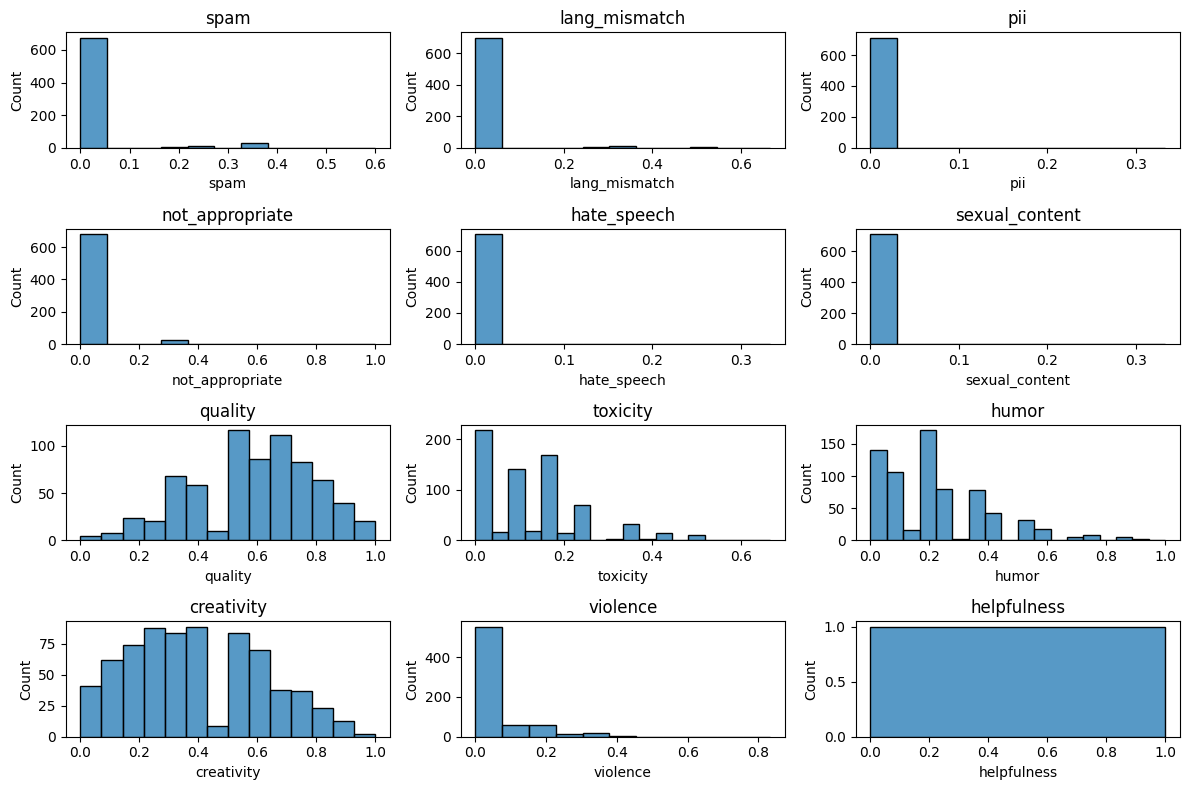

In [46]:


# Устанавливаем размер графиков
plt.figure(figsize=(12, 8))

# Цикл по колонкам и построение гистограмм
for i, column in enumerate(labels_names, 1):
    plt.subplot(4, 3, i)  # Подсетка 2 строки, 3 колонки
    sns.histplot(top_lvl_ru_instruct[column])  # Строим гистограмму с KDE
    plt.title(column)  # Название каждого графика

# Отображаем графики
plt.tight_layout()  # Оптимизируем размещение
plt.show()

In [47]:
for col in labels_names:
    max_val = top_lvl_ru_instruct[col].max()
    print(col)
    print(top_lvl_ru_instruct.query(f"{col} == {max_val}")['text'].values[0], end='\n\n')

spam
Шаги и действия последовательности задач
Шаги являются основными компонентами последовательности задач. Они могут включать такие команды, как:
Настройка и запись ОС эталонного компьютера
Установка Windows, драйверов оборудования, клиента Configuration Manager и программного обеспечения на целевом компьютере
Действия шага определяют команды шага последовательности задач. Существует два типа действий:
Действие, определяемое с помощью строки командной строки, называется пользовательским действием.
Действие, предопределенное Configuration Manager, называется встроенным действием.

lang_mismatch
Please rewrite Little Red Riding Hood fairy tail using only emojis.

pii
Меня выбесил заказчик, я очень хочу ответить вежливо, но у меня горит с его вопросов. Перепиши, пожалуйста, моё письмо так, чтобы оно звучало вежливо и клиент не обиделся.
Привет, Женёк Как же ты достал со своими правками. Было тз, что поверх сделанного не больше трех правок. ТЫ МНЕ УЖЕ 7 ЗА ПоСЛЕДНИЙ ЧАС НАКИНУЛ! Госпади,

In [48]:
top_lvl_ru_instruct = top_lvl_ru_instruct[(top_lvl_ru_instruct['spam'] <= 0.5) &\
                                          (top_lvl_ru_instruct['lang_mismatch'] <= 0.5) &\
                                          (top_lvl_ru_instruct['toxicity'] <= 0.5) & \
                                          (top_lvl_ru_instruct['quality'] >= 0.4) & \
                                          (top_lvl_ru_instruct['lang_mismatch'] <= 0.5) & \
                                          (top_lvl_ru_instruct['violence'] <= 0.5)]

In [49]:
top_lvl_ru_instruct.shape

(577, 24)

In [50]:
top_lvl_ru_instruct.head()

,text,review_count,labels,text_len,toxicity_detoxify,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,index,spam,lang_mismatch,pii,not_appropriate,hate_speech,sexual_content,quality,toxicity,humor,creativity,violence,helpfulness
0,Напиши информацию о игре Hytale,3,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",31,0.000876,0.006206,0.039024,0.007062,0.031851,0.002483,0.001191,82,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,0.000000,0.000000,0.083333,0.000000,NaN
1,"Докончи поговорку, без труда не выловишь и",3,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",42,0.043254,0.000322,0.003794,0.000290,0.009484,0.017009,0.001749,185,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.062500,0.187500,0.375000,0.000000,NaN
2,"У меня угнали машину, что мне делать?",3,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",37,0.004926,0.000403,0.003004,0.000552,0.001443,0.002428,0.000256,315,0.0,0.0,0.0,0.0,0.0,0.0,0.583333,0.250000,0.083333,0.333333,0.083333,NaN
3,Какие произведения Булгакова связаны с Иерусал...,3,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",51,0.001587,0.000459,0.003759,0.002968,0.003093,0.000296,0.000162,327,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.166667,0.083333,0.750000,0.000000,NaN
4,Плюсы и минусы языков программирования C++ и R...,3,"{'name': ['spam', 'lang_mismatch', 'pii', 'not...",61,0.000326,0.001647,0.014770,0.002219,0.012556,0.000652,0.000408,427,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [51]:
prompt_list = top_lvl_ru_instruct['text'].tolist()

In [52]:
prompts_train, prompts_test = train_test_split(prompt_list, test_size=0.2, random_state=52)

In [53]:
len(prompts_train), len(prompts_test)

(461, 116)

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

cache_dir="/home/jupyter/datasphere/project/huggingface_cache_dir/"

tokenizer = AutoTokenizer.from_pretrained("IlyaGusev/saiga_llama3_8b", cache_dir=cache_dir)
model = AutoModelForCausalLM.from_pretrained("IlyaGusev/saiga_llama3_8b", 
                                             cache_dir=cache_dir,
                                             load_in_8bit=True,
                                             torch_dtype=torch.bfloat16)
# model = model.to("cuda")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )


In [4]:
generation_config = GenerationConfig.from_pretrained("IlyaGusev/saiga_llama3_8b")
print(generation_config)

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": 128009,
  "max_new_tokens": 1536,
  "pad_token_id": 128000,
  "repetition_penalty": 1.12,
  "temperature": 0.2,
  "top_k": 30,
  "top_p": 0.9
}



In [5]:
model.device

device(type='cuda', index=0)

In [ ]:
system_prompt = """
Ответ должен быть кратким, полезным и ясным.
"""

def generate_response(query, system_prompt=None):
    if system_prompt:
        prompt = tokenizer.apply_chat_template([{
            "role": "system",
            "content": system_prompt
        }, {
            "role": "user",
            "content": response
        }], tokenize=False, add_generation_prompt=True)
    else:
        prompt = tokenizer.apply_chat_template([{
            "role": "user",
            "content": query
        }], tokenize=False, add_generation_prompt=True)
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(**data, generation_config=generation_config)[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    return output


In [58]:
response = generate_response(prompts_train[0])
print(prompts_train[0])
print('=' * 10)
print(response)

Как выключить телевизор?
Чтобы выключить телевизор, вам нужно выполнить следующие шаги:

1. **Найдите кнопку питания**: Обычно она находится на панели управления или на задней части устройства.

2. **Нажмите на кнопку "Выкл." или "Power"**: Это может быть иконка с изображением выключенного экрана или буквами "Off". Кнопка может иметь разные названия в зависимости от модели вашего телевизора.

3. **Подтвердите действие (если требуется)**: В некоторых моделях после нажатия на кнопку "Выкл." появляется запрос о подтверждении выхода из режима работы. Нажмите "Да" или "ОК", чтобы завершить процесс.

4. **Телевизор должен автоматически выключиться**: После того как вы подтвердили желание выключить устройство, оно должно начать тормозить работу и затем полностью выключаться.

Если у вас возникнут проблемы с выключением телевизора, проверьте, что все кабели подключены правильно и не перепутаны. Также попробуйте перезагрузить аппарат, если он зависает при попытке выключения. Если проблема сохра

In [59]:
response = generate_response(prompts_train[0], system_prompt=system_prompt)
print(prompts_train[0])
print('=' * 10)
print(response)

Как выключить телевизор?
Для выключения телевизора следуйте этим шагам:
1. Найдите кнопку питания.
2. Нажмите на кнопку "Выкл." или "Power".
3. Подтвердите действие, если требуется.
4. Телевизор должен автоматически выключиться.

При проблемах с выключением проверьте правильность подключения кабелей и перезагрузите устройство. Если проблема сохраняется, обратитесь за помощью к специалисту по ремонту электроники.


In [60]:
def prepare_train_data(prompts):
    data = []
    for p in tqdm(prompts):
        chosen = generate_response(p, system_prompt=system_prompt)
        rejected = generate_response(p)
        data.append({'prompt': p, 'chosen': chosen, 'rejected': rejected})
    return data
        

In [61]:
train_data = prepare_train_data(prompts_train[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

In [62]:
train_data_pd = pd.DataFrame(train_data)

In [63]:
from datasets import Dataset

dataset_train = Dataset.from_pandas(train_data_pd)

In [64]:
dataset_train

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 50
})

In [65]:
dataset_train.to_json("/home/jupyter/datasphere/project/train_dataset.json", orient="records")

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 166.42ba/s]


537918

In [68]:
test_data = prepare_train_data(prompts_test[:20])

  0%|          | 0/20 [00:00<?, ?it/s]

In [71]:
test_data_pd = pd.DataFrame(test_data)

In [72]:
dataset_test = Dataset.from_pandas(test_data_pd)

In [73]:
dataset_test

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 20
})

In [3]:
dataset_test.to_json("/home/jupyter/datasphere/project/test_dataset.json", orient="records")

NameError: name 'dataset_test' is not defined

In [ ]:
ds = load_dataset('json', data_files='/home/jupyter/datasphere/project/train_dataset.json')['train']
ds_pd = ds.to_pandas()
train_df, test_df = ds_pd.iloc[:10], ds_pd.iloc[10:15]

In [ ]:
dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

Создание шкалы для оценки ответов:

Разработайте критерии для оценки качества ответов. Например:

Полезность: Насколько ответ полезен и отвечает на вопрос?

Ясность: Ответ четкий и легко понимается?

In [7]:
def evaluate_response(response):
    evaluation_prompt = """
    Оцени ответ модели по следующим критериям:
    1. Полезность
    2. Краткость
    3. Ясность
    
    Полезность:
    1 — Ответ не решает проблему.
    2 — Содержит незначительную полезную информацию.
    3 — Решает часть задачи, но не полностью.
    4 — Полезен, охватывает ключевые моменты.
    5 — Полностью полезен, решает проблему.
    
    Краткость:
    1 — Ответ слишком длинный и лишний.
    2 — Содержит лишние детали.
    3 — Умеренно краток, но можно сократить.
    4 — Краток и по делу.
    5 — Максимально краток, без лишнего.
    
    Ясность:
    1 — Ответ неясен.
    2 — Сложно понять, требует доработки.
    3 — Понятен, но есть сложные формулировки.
    4 — Ясный, легко воспринимаемый.
    5 — Абсолютно ясен.

    Оцени каждый критерий по 5-балльной шкале и предоставь результат в виде словаря.
    Ответ должен содержать только словарь с оценками без дополнительной информации.
    Не добавляй переносы на следующую строку.
    
    Пример: '{'полезность': 2, 'краткость': 1, 'ясность': 3}'.
    """
    prompt = tokenizer.apply_chat_template([{
        "role": "system",
        "content": evaluation_prompt
    }, {
        "role": "user",
        "content": response
    }], tokenize=False, add_generation_prompt=True)
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(**data, generation_config=generation_config)[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    return ast.literal_eval(output)
   

In [66]:
train_base = []
for prompt in prompts_train[:5]:
    response = generate_response(prompt)
    eval_res = evaluate_response(response)
    result = {'prompt': prompt,
              'response': response,
              'usefulness': eval_res['полезность'],
              'brevity': eval_res['краткость'],
              'clarity': eval_res['ясность']}
    train_base.append(result)
train_base_df = pd.DataFrame(train_base)

In [67]:
train_base_df

,prompt,response,usefulness,brevity,clarity
0,Как выключить телевизор?,"Чтобы выключить телевизор, вам нужно выполнить...",4,2,4
1,"Известно, что LLM склонны фантазировать, с уве...","Я разработан таким образом, чтобы предоставлят...",4,4,5
2,Что такое сепульки?,Сепульки — это древние деревянные или каменные...,4,4,5
3,Как стать программистом?,"Стать программистом — это не только профессия,...",5,3,4
4,Какой пакетный менеджер для систем на базе ядр...,Выбор лучшего пакетного менеджера для системы ...,4,3,4


In [8]:
from peft import LoraConfig
 
# LoRA config based on QLoRA paper & Sebastian Raschka experiment
peft_config = LoraConfig(
        lora_alpha=128,
        lora_dropout=0.05,
        r=256,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

In [9]:
import torch
from transformers import TrainingArguments
 
args = TrainingArguments(
    output_dir="/home/jupyter/datasphere/project/saiga_dpo",               # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,         # batch size per device during training
    per_device_eval_batch_size=4,           # batch size for evaluation
    gradient_accumulation_steps=1,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    learning_rate=5e-5,                     # 10x higher LR than QLoRA paper
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.1,                       # warmup ratio based on QLoRA paper
    lr_scheduler_type="cosine",             # use cosine learning rate scheduler
    logging_steps=4,                       # log every 25 steps
    save_steps=8,                           # when to save checkpoint
    save_total_limit=2,                     # limit the total amount of checkpoints
    evaluation_strategy="steps",            # evaluate every 1000 steps
    eval_steps=4,                             # use tf32 precision
    push_to_hub=False,                      # push model to hub
)
 
dpo_args = {
    "beta": 0.1,                            # The beta factor in DPO loss. Higher beta means less divergence
    "loss_type": "sigmoid"                  # The loss type for DPO.
}

In [10]:
from trl import DPOTrainer

prompt_length = 1024
max_seq_length = 1512
 
trainer = DPOTrainer(
    model,
    ref_model=None, # set to none since we use peft
    peft_config=peft_config,
    args=args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    tokenizer=tokenizer,
    # max_length=max_seq_length,
    # max_prompt_length=prompt_length,
    beta=dpo_args["beta"],
    loss_type=dpo_args["loss_type"],
)

2024-09-29 20:46:49.819335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Map: 100%|██████████| 5/5 [00:00<00:00, 203.37 examples/s]


In [11]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

 44%|████▍     | 4/9 [01:06<01:22, 16.48s/it]

{'loss': 0.3474, 'learning_rate': 3.456708580912725e-05, 'rewards/chosen': 3.2203238010406494, 'rewards/rejected': -1.8093945980072021, 'rewards/accuracies': 0.5, 'rewards/margins': 5.029718399047852, 'logps/rejected': -223.5740966796875, 'logps/chosen': -116.51332092285156, 'logits/rejected': -0.6068012118339539, 'logits/chosen': -1.0703774690628052, 'epoch': 1.33}



  0%|          | 0/2 [00:00<?, ?it/s]
                                             
100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
                                             

{'eval_loss': 2.1039460989413783e-05, 'eval_runtime': 9.9436, 'eval_samples_per_second': 0.503, 'eval_steps_per_second': 0.201, 'eval_rewards/chosen': 9.148329734802246, 'eval_rewards/rejected': -1.425432562828064, 'eval_rewards/accuracies': 1.0, 'eval_rewards/margins': 10.573761940002441, 'eval_logps/rejected': -177.52789306640625, 'eval_logps/chosen': -60.204246520996094, 'eval_logits/rejected': -0.9004875421524048, 'eval_logits/chosen': -1.1338940858840942, 'epoch': 1.33}


 89%|████████▉ | 8/9 [02:22<00:18, 18.38s/it]

{'loss': 0.0, 'learning_rate': 1.9030116872178316e-06, 'rewards/chosen': 9.399824142456055, 'rewards/rejected': -10.51403522491455, 'rewards/accuracies': 1.0, 'rewards/margins': 19.91385841369629, 'logps/rejected': -309.7375793457031, 'logps/chosen': -51.970680236816406, 'logits/rejected': -0.8657321929931641, 'logits/chosen': -1.0900121927261353, 'epoch': 2.67}



  0%|          | 0/2 [00:00<?, ?it/s]
                                             
100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
                                             

{'eval_loss': 3.847435436910018e-06, 'eval_runtime': 9.9471, 'eval_samples_per_second': 0.503, 'eval_steps_per_second': 0.201, 'eval_rewards/chosen': 10.183496475219727, 'eval_rewards/rejected': -2.2066094875335693, 'eval_rewards/accuracies': 1.0, 'eval_rewards/margins': 12.390106201171875, 'eval_logps/rejected': -185.28369140625, 'eval_logps/chosen': -50.051971435546875, 'eval_logits/rejected': -0.9745545387268066, 'eval_logits/chosen': -1.1516094207763672, 'epoch': 2.67}


100%|██████████| 9/9 [06:31<00:00, 43.48s/it]

{'train_runtime': 391.3162, 'train_samples_per_second': 0.077, 'train_steps_per_second': 0.023, 'train_loss': 0.15440694614550404, 'epoch': 3.0}


TrainOutput(global_step=9, training_loss=0.15440694614550404, metrics={'train_runtime': 391.3162, 'train_samples_per_second': 0.077, 'train_steps_per_second': 0.023, 'train_loss': 0.15440694614550404, 'epoch': 3.0})

In [ ]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, pipeline
 
# Path to saved peft adapter model
# peft_model_id = args.output_dir # or
peft_model_id = "/home/jupyter/datasphere/project/saiga_dpo/checkpoint-8"
 
# Load Model with PEFT adapter
model = AutoPeftModelForCausalLM.from_pretrained(
  peft_model_id,
  device_map="cuda",
  load_in_8bit=True,
  torch_dtype=torch.bfloat16
)
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)

In [20]:
system_prompt = """
Ответ должен быть кратким, полезным и ясным.
"""

def generate_response(query, model, tokenizer, system_prompt=None):
    if system_prompt:
        prompt = tokenizer.apply_chat_template([{
            "role": "system",
            "content": system_prompt
        }, {
            "role": "user",
            "content": response
        }], tokenize=False, add_generation_prompt=True)
    else:
        prompt = tokenizer.apply_chat_template([{
            "role": "user",
            "content": query
        }], tokenize=False, add_generation_prompt=True)
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to('cuda') for k, v in data.items()}
    output_ids = model(**data)
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    return output


In [21]:
train_df['prompt'].values[0]

'Как выключить телевизор?'

In [22]:
generate_response(train_df['prompt'].values[0], trainer, tokenizer, system_prompt=None)

TypeError: 'DPOTrainer' object is not callable

In [13]:
torch.cuda.empty_cache()